In [1]:
import os
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

import torch as T
import torch.nn as nn
from torch import optim
from tensorboardX import SummaryWriter
import wandb

from datagenerator import generate_data, SynthSignalsDataset, get_params_from_json
from model import UNet1SC # Unet1SC has a smaller number of params

In [2]:
def train_epoch(epoch, train_ldr, criterion, optimizer, batch_size, scheduler):
    
    net.train()
    epoch_loss = 0
    loss = criterion
    
    for (batch_idx, batch) in enumerate(train_ldr):
    
        signals = batch['signals']
        gt = batch['gt'].float()

        if signals.dim()==2:
            signals = signals[:,None].to(device) # For single channel signals
        else:
            signals = signals.to(device)
            
        targets = gt.permute((0,2,1)).to(device)
        targets_as_class = T.argmax(targets, dim=1)
        
        outputs = net(signals)
        if isinstance(criterion, nn.CrossEntropyLoss):
            ClassProbabilityChannels = 1.0*(outputs[0] - 0.0)
            # Note: this ONLY works for BCE loss
            L = loss(ClassProbabilityChannels, targets_as_class)
        
        elif isinstance(criterion, nn.MSELoss):
            Outputs = outputs[0]
            L = loss(Outputs, targets)

        epoch_loss += L.item()/len(train_ldr)
        
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        
    return epoch_loss

In [3]:
def val_epoch(nepoch, val_loader, batch_size, criterion):
    
    net.eval()
    loss = criterion
    L_v = 0
    
    for (batch_idx, batch) in enumerate(val_ldr):
       
        signals = batch['signals']
        gt = batch['gt'].float() 
    
        # If there is no "batch" dimension (only one signal)...
        if signals.dim()==2: 
        # Appends a dummy dimension to signals, representing batch dimension
            signals = signals[:,None].to(device) 
        else:
            signals = signals.to(device)
    
#       signals = signals.to(device)
        targets = gt.permute((0,2,1)).to(device)
    
        targets_as_class = T.argmax(targets, dim=1)

        # Perhaps a bit of amplification (1.1) helps 
        # the targets be reached by the sigmoidal....? 
        outputs = net(signals)
        if isinstance(criterion, nn.CrossEntropyLoss):
            ClassProbabilityChannels = (outputs[0])
            # Note: this ONLY works for BCE loss
            L_v += loss(ClassProbabilityChannels, targets_as_class)
        
        elif isinstance(criterion, nn.MSELoss):
            Outputs = outputs[0]
            L_v += loss(Outputs, targets)

    return L_v

In [4]:
def train_model(train_ldr, val_ldr, net, device, epochs, batch_size, lr, Loggers, save_cp=True):
    
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    criterion = nn.MSELoss()
    
    lowest_v_L = -1
    for epoch in tqdm(range(epochs)):
        
        t_loss = train_epoch(epoch, train_ldr, criterion, optimizer, batch_size, scheduler)
        
        v_loss = val_epoch(epoch, val_ldr, batch_size, criterion)
        
        scheduler.step()

        if 'WandB' in Loggers:
            wandb.log({'Train Loss': t_loss,'Val. Loss': v_loss})
        
        if 'TB' in Loggers:
            writer.add_scalars('Losses',{
                'Train Loss': t_loss,
                'Val. Loss': v_loss,
            }, epoch)
        
        if save_cp:
            if v_loss < lowest_v_L:
            
                state_dict = net.state_dict()
                
                #if device=="cuda":
                state_dict = net.module.state_dict()
                T.save(state_dict, './savedmodel/model'+f'CP{epoch + 1}.pth')
                print('Checkpoint {} saved !'.format(epoch + 1))
                
                lowest_v_L = precision
    
    writer.close()
    
    state_dict = net.state_dict()
    T.save(state_dict, './savedmodels/model'+f'Final.pth')
        

In [5]:
# Loggers = ['WandB','TB']
Loggers = ['TB']
N_t = 3000 # Number of training samples
N_v = 32 # Number of samples used in validation
epochs = 100
lr = 0.0001

# device = ("cuda" if T.cuda.is_available() else "cpu")
# device = ("mps" if T.backends.mps.is_available() else "cpu")

if T.cuda.is_available():
    device = "cuda"
elif T.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

T.device(device)

# In the case that MPS/CUDA just will not work:
# device = "cpu"

print("Using ",device)

if 'TB' in Loggers:
    writer = SummaryWriter() # Using TBX for logging

if 'WandB' in Loggers:
    wandb.login() # Using wandb for visualising results

# if a directory for saving models does not exist, create it
if not os.path.exists('./savedmodels'):
    os.makedirs('./savedmodels')

# if a directory for saving figures does not exist, create it
if not os.path.exists('./Figures'):
    os.makedirs('./Figures')


Using  mps


In [7]:

params = get_params_from_json('./Parameters/params.json')

params['noise_level'] = 0.2 # Sigma - uniform Gaussian SD = 0.2
params['randomoffset'] = False

train_ds = SynthSignalsDataset(params, num_samples=N_t, device=device)
val_ds = SynthSignalsDataset(params, num_samples=N_v, device=device)

train_ldr = T.utils.data.DataLoader(train_ds,
            batch_size=32, shuffle=True)

val_ldr =  T.utils.data.DataLoader(val_ds,
            batch_size=32, shuffle=True)

net = UNet1SC(n_channels=1, n_classes=6)
net.to(device)

#dir_data = f'./data/{args.folder}'
#dir_checkpoint = f'./checkpoints/{args.folder}_b{args.batchsize}/'
#dir_summary = f'./runs/{args.folder}_b{args.batchsize}'

if 'WandB' in Loggers:
    training_run = wandb.init(
        # Set the project where this run will be logged
        project="onedseg",
        # Track hyperparameters and run metadata
        config={
            "learning_rate": lr,
            "epochs": epochs,
        },
    )

train_model(train_ldr, val_ldr, net, device, epochs, batch_size=32, lr=lr, Loggers=Loggers)

if 'WandB' in Loggers:
    wandb.finish()

100%|██████████| 100/100 [02:59<00:00,  1.79s/it]


## Testing of the network

In [10]:
sns.set_theme(style='white')
sns.set(rc={'figure.figsize':(10,6)}, font_scale=2.5)
sns.set_style({'axes.facecolor':'white', 'grid.color': '.8', 'font.family':'Times New Roman'})

plt.rcParams.update({
    "text.usetex": True,
})

In [11]:
from datagenerator import makesignal
params['noise_level'] = 0.2 # Sigma - uniform Gaussian SD = 0.0

x_tmp, gt, signalclass = makesignal(params)
x_tmp_exp = x_tmp[:,None]
x = T.tensor(x_tmp_exp, dtype=T.float32).to(device)


In [23]:
def predict(x, net, device):
    """
    Predicts the segmentation of the input signal using the trained model.
    """
    with T.no_grad():
        x = x.to(device)
        net.eval()
        outputs = net(x)
        pout = outputs[0].cpu().numpy().squeeze()
        wsout = outputs[1].cpu().numpy().squeeze()

        return pout, wsout


In [24]:
out, ws = predict(x, net, device)

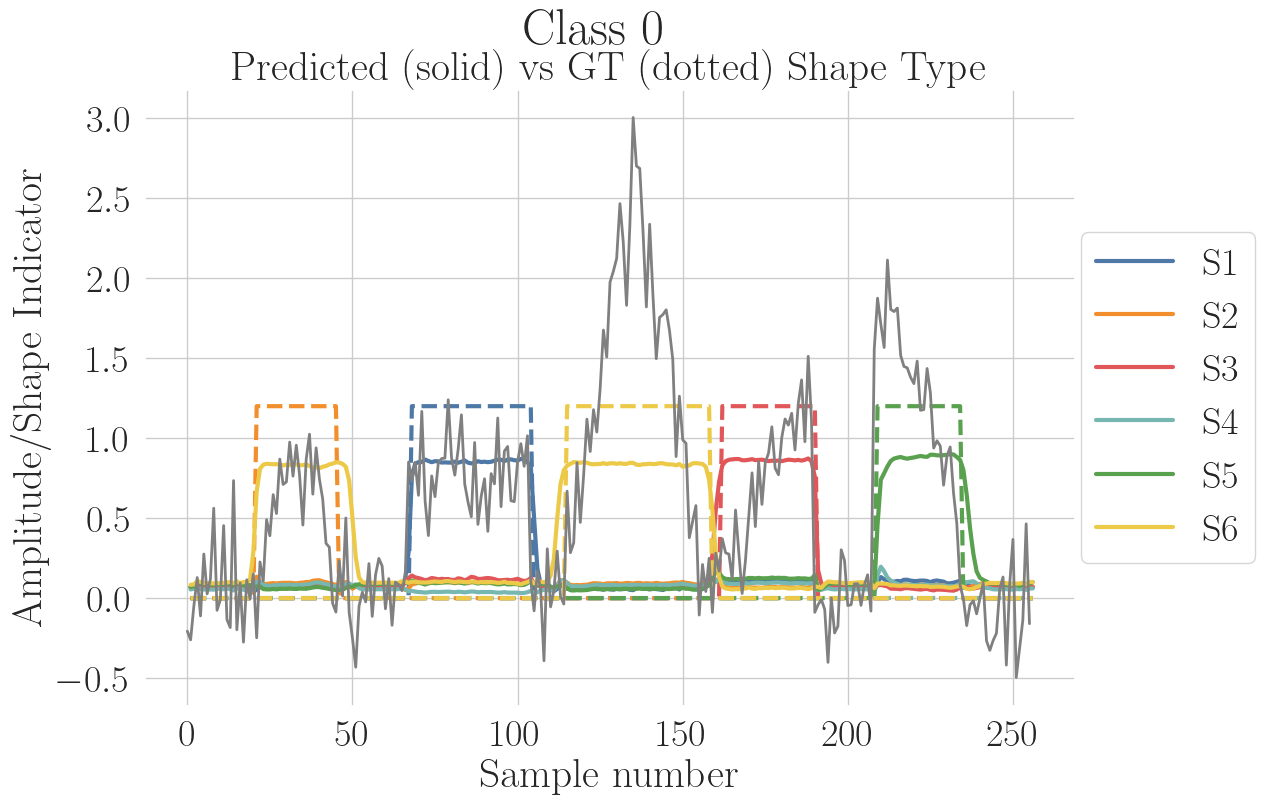

In [25]:
fig = plt.figure(figsize=(12,8))
ax = plt.gca()

# Modern color palette (Tableau 10)
colours = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F', '#EDC948']

ShapeLikelihood = np.transpose(out)

for i in range(ShapeLikelihood.shape[1]):
    plt.plot(np.arange(1,257), 1.2*gt[:,i], ls='--', lw=3, color=colours[i])

    plt.plot(np.arange(1,257), ShapeLikelihood[:,i], lw=3, color=colours[i])

plt.plot(x_tmp[0], ls='-', lw=2, color='#808080')

# Create a custom legend for the six classes
legend_handles = [plt.Line2D([0], [0], color=col, lw=3) for col in colours]
plt.legend(legend_handles, ['S1', 'S2', 'S3', 'S4', 'S5', 'S6'], bbox_to_anchor=(1.1, 0.5), loc='center')

# Add labels and title
plt.xlabel('Sample number')
plt.ylabel('Amplitude/Shape Indicator')
plt.title('Predicted (solid) vs GT (dotted) Shape Type')
plt.suptitle('Class ' + str(signalclass))

# Save the plot
plt.savefig('DensePredictions.svg')

Text(0.5, 1.0, 'Height of orange trace corresponds to (int) class assignment, 1..6')

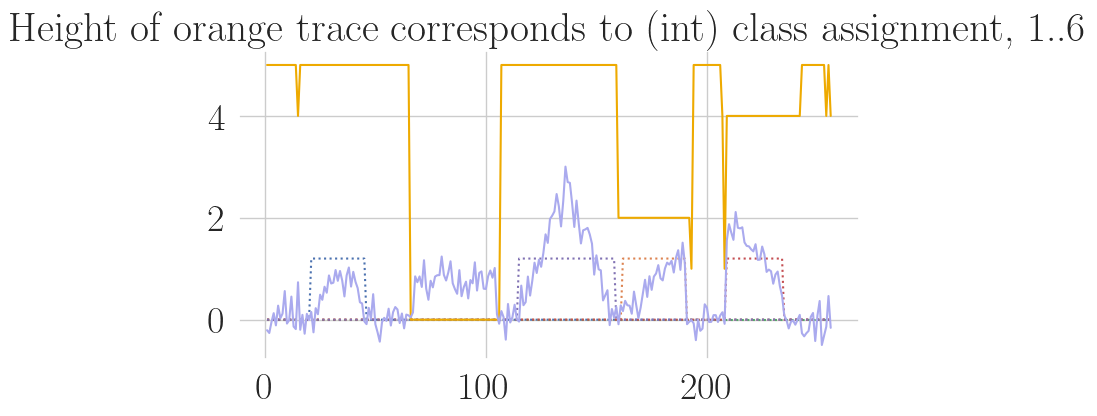

In [26]:
fig = plt.figure(figsize=(8,4))
ax = plt.gca()

ax.set_prop_cycle(None)
plt.plot(np.arange(1,257),1.2*gt[:,1:],ls=':')

plt.plot(np.arange(1,257), 1+ws, '#EEAA00', 
         np.arange(1,257),x_tmp[0],'#AAAAEE')
plt.title('Height of orange trace corresponds to (int) class assignment, 1..6')

In [ ]:
Thresh = 0.2
ShapeLikelihoodThresholded = ShapeLikelihood>Thresh
plt.plot(ShapeLikelihoodThresholded, '#FF0000', ls = ':', lw=3)
plt.plot(gt, '#0000FF', ls = '--', lw=3)
Intersection = np.logical_and(ShapeLikelihoodThresholded, gt)
Union = np.logical_or(ShapeLikelihoodThresholded, gt)
Jaccard = np.sum(Intersection)/np.sum(Union)
plt.title('Jaccard Index: ' + str(Jaccard))

## Multiple runs of signal generator and classifier
## including using different noise levels.


In [109]:
from datagenerator import makesignal
net.eval()
NTrials = 10
NNoiseLevels = 10
NoiseLevels = np.linspace(0.1,1.0,NNoiseLevels)

JACCI = np.zeros((NTrials,NNoiseLevels))
JI = np.zeros(10)
Thresh = 0.25

for i in range(NTrials):
    for j in range(NNoiseLevels):
        x_tmp, gt, signalclass = makesignal(noise_level=NoiseLevels[j])
        x_tmp_exp = x_tmp[:,None]
        x = T.tensor(x_tmp_exp, dtype=T.float32).to(device)

        out = net(x)[0].detach().squeeze().cpu().numpy()

        ShapeLikelihood = np.transpose(out)

        ShapeLikelihoodThresholded = ShapeLikelihood>Thresh
        Intersection = np.logical_and(ShapeLikelihoodThresholded, gt)
        Union = np.logical_or(ShapeLikelihoodThresholded, gt)
        Jaccard = np.sum(Intersection)/np.sum(Union)
        JACCI[i,j] = Jaccard



In [ ]:
plt.errorbar(NoiseLevels, np.mean(JACCI, axis=0), yerr=np.std(JACCI, axis=0), fmt='o', capsize=5)
plt.ylim(-0.01,1.01)
plt.xlim(-0.01,1.01)
plt.grid('on')
plt.xlabel('Noise Level')
plt.ylabel('Jaccard Index')
plt.title('Jaccard Index vs Noise Level')
plt.savefig('JaccardIndex.svg')

In [ ]:
N=sum(p.numel() for p in net.parameters() if p.requires_grad)
print(N)

## Saliency Maps for Signal Segmentation

In [ ]:
import torch as T

from datagenerator import makesignal
from model import UNet1SC
from captum.attr import Saliency

if T.cuda.is_available():
    device = "cuda"
elif T.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"


x_tmp, gt_tmp, signalclass = makesignal(noise_level=0.3)
x_tmp_exp = x_tmp[None,:]
x = T.tensor(x_tmp_exp, dtype=T.float32).to(device)

bL = T.zeros(x.size()).to(device)
gt = T.tensor(gt_tmp, dtype=T.float32).to(device)
targets_as_class = T.argmax(gt, dim=1).to(device)

T.device(device)

# Set up the model structure
net = UNet1SC(n_channels=1, n_classes=6)
net.to(device)

modelfilename = './savedmodels/'+f'modelFinal.pth'
net.load_state_dict(T.load(modelfilename, map_location=T.device(device)))

net.eval()

According to `captum` documentation, it is necessary to collapse the output of a 
network to a single scalar; presumably, this will be compared to the target class. The issue with the current network is that we have logit output signals, one for each class, at every time point. 

In principle, creating a wrapper that sums across these dimensions can fix matters. Need to ensure that summatiom is in the right dimensions.

In [10]:
"""
This wrapper applies the signal segmentation model output and sums the scores for
all time point prediction "likelihoods" for class, returning a tensor with a single value for
each class. This makes it "compatible" with the expectations of the 
captum package, which expects a single output scalar per class per example, 
as opposed to a individual likelihoods per class as a function of time.

It should theoretically be possible to sift out the time points that will
be used for summing likelihoods, but these should be added into the arguments
to the wrapper (captum permits this).
"""
def temporal_segmentation_wrapper(x):
    model_out = net(x)[0]
    # Creates binary matrix with 1 for original argmax class for each pixel
    # and 0 otherwise. Note that this may change when the input is ablated
    # so we use the original argmax predicted above, out_max.
    return model_out.sum(dim=2)


In [ ]:
saliency = Saliency(temporal_segmentation_wrapper)
grads = saliency.attribute(x, target=5)

In [ ]:
plt.plot(10.0*grads.squeeze().cpu().numpy())
plt.plot(x.squeeze().cpu().detach().numpy())
plt.plot(gt.squeeze().cpu().detach().numpy())

## Below, this loads a saved inference model
Do not expcet this to work well if:

 - The data distribution has changed from initial training of this pre-saved model
 
 - If you are trying to observe the inference of a new model on data

In [ ]:
N_t = 3000
N_v = 32
device = ("cuda" if T.cuda.is_available() else "cpu")
device = ("mps" if T.backends.mps.is_available() else "cpu")
T.device(device)

print("Using ",device)

net = UNet1SC(n_channels=1, n_classes=6)
net.to(device)

# This loads a pre-trained network; ditributed with the repo
modelfilename = './savedmodels/modelSC1.pth'

net.load_state_dict(T.load(modelfilename, map_location=T.device(device)))

net.eval()
out = net(x).detach()

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(1,257),np.transpose(out[0][1:].cpu().numpy()),np.arange(1,257),x_tmp[0])
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(1,257),1.2*gt[:,1:],ls=':')
plt.legend(['S1','S2','S3','S4','S5'])
plt.xlabel('Sample number')
plt.ylabel('Amplitude/Class Indicator')
plt.title('Predicted (solid) vs GT (dotted) Shape Type')

In [ ]:
sns.set_theme(style='white')
sns.set(rc={'figure.figsize':(10,6)}, font_scale=1.5)
sns.set_style({'axes.facecolor':'white', 'grid.color': '.8', 'font.family':'Times New Roman'})

plt.rcParams.update({
    "text.usetex": True,
})

In [ ]:
# A single realisation of a signal, with different types of components
fig,ax = plt.subplots(1, figsize=(10,6))
ax.plot(range(len(x_tmp[0,:])),x_tmp[0,:])
plt.gca().set_prop_cycle(None)
# ax.plot(range(len(y[0,:])),gt)
ax.set_ylim([-4.5, 4.0])
ax.text(1,3,'Signal Amplitude')
ax.set_xlabel('Time Index')
axins = inset_axes(ax, width="100%", height="10%", 
                    bbox_to_anchor=(0.0, 0.01, 1.0, 0.95),
                    bbox_transform=ax.transAxes, loc=3)

axins.set_axis_off()
axins.text(-1,3.5,'Ground Truth')
plt.gca().set_prop_cycle(None)
axins.plot(np.arange(1,257),1.2*gt[:,1:],lw=3)
plt.gca().set_prop_cycle(None)
axins.plot(np.arange(1,257),np.transpose(out[0][1:].cpu().numpy()),ls=':',lw=3)
axins.legend(['S1','S2','S3','S4','S5'])
plt.savefig('sigsegdemo.svg')

## DO NOT GO BELOW THIS LINE UNLESS YOU RETRAIN THE NETWORK
The bit of code below was intended to be used to save new instances of network training. If not doing
that, then ignore.

In [ ]:
state_dict = net.state_dict()
T.save(state_dict, './savedmodels/modelSC'+f'{1}.pth')

In [16]:
gt = T.tensor(gt_tmp, dtype=T.float32)

In [ ]:
plt.plot(15*T.sum(T.softmax(gt,dim=0)*T.arange(0,6),dim=1))